In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drug-consumption-classification/drug_consumption.csv


# Dataset Information
The dataset used in this analysis comes from the [Drug Consumption Classification Dataset](https://www.kaggle.com/datasets/mexwell/drug-consumption-classification), courtesy of Kaggle.

The dataset contains the records of 1885 respondants regarding their drug habits, psychological profile results, and some basic information. The intent of this analysis is to map clustered psychological profile factors onto active drug use.

The psychological factors collected for this data set come from [the "Big 5" personality traits](https://en.wikipedia.org/wiki/Big_Five_personality_traits) (neuroticism, extraversion, openness, agreeableness, conscientiousness) as well as impulsiveness and sensation seeking. This link goes to the Wikipedia article for the Big 5 traits. Those interested in this topic are encouraged to look deeper into primary sources on the subject. These factors are obtained using a questionnaire administered to each respondant. These, as well as the demographic information are pre-normalized within the dataset in some fashion not detailed in the dataset. While this would be a nuisance in regards to the unordered categorical fields of country and ethnicity, those fields, as well as education will be ignored for this analysis.

The reason for this is that education, country, and ethnicity are complex and interrelated in a way that is outside of my domain knowledge as well as the the scope of this analysis. For example, a given ethnicity will be prone to different socioeconomic statuses depending on which country the respondant lives in, which goes on to affect what level of education is available to them. All of which are likely to influence if the person is willing to use a given drug, or what kind of drug they may use. Further, the reasons for ending one's education at any given point is very different in any given country. Being unable to afford higher education, despite ability, is a common reason for Americans to stop after high school. Investigating these factors merits an analysis all it's own and so is going to be ignored here.

The drug usage data relates to 18 legal and illegal substances as shown below. One of note is Semeron. This drug is ficticious and was used by researchers to weed out over-responders. These values are ordinal categorical values of CL[0-6], with Cl0 indicating a person has never used a given substance, and CL6 indicating that the respondant has used it in the last day. For the sake of mapping, a respondant is deemed an "active user" if they have responded that they have used a given substance within the past month. While a rough estimate and likely frought with confounding factors, it will serve for this initial exploration.

One final reminder for anyone that runs this notebook. Final cluster designations are randomized every time the analysis is run. Thus the annotations reference specific clusters but are liable to be different than when this notebook is rerun. All specific references refer to the clusters as shown at the time of writing.

All the data fields more thoroughly, with additional data as deemed necessary:
* Respondant demographic information
    * Age
    * Gender
    * Education
    * Country
    * Ethnicity
* Psychological factors
    * NScore - Neuroticism
    * EScore - Extraversion
    * OScore - Openness
    * AScore - Agreeableness
    * CScore - Conscientiousness
    * Impulsive - Impulsiveness
    * SS - Sensation seeking
* Drugs
    * Alcohol
    * Amphetamines
    * Amyl nitrite
    * Benzodiazepine
    * Cannabis
    * Chocolate - It is unclear if this refers to the legal food, or a street name for the illegal opium
    * Cocaine
    * Caffeine
    * Crack
    * Ecstasy
    * Heroin
    * Ketamine
    * Legal highs
    * LSD
    * Methadone
    * Mushrooms
    * Nicotine
    * Volatile substance abuse - Huffing paint
    * Semeron - Ficticious drug to weed out over-responders

# Exploration

As noted above, the numeric data is pre-normalized, and the drug use fields are string values. The next few cells show a quick sample of the data, list out the column names, and checks for NaN or null values. As this dataset has been significantly cleaned beforehand, it should not be surprising that there are no such values.

In [3]:
rawData = pd.read_csv("/kaggle/input/drug-consumption-classification/drug_consumption.csv")
rawData.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [4]:
rawData.columns

Index(['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
       'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol',
       'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms',
       'Nicotine', 'Semer', 'VSA'],
      dtype='object')

In [5]:
rawData.isna().sum(axis=0)

ID           0
Age          0
Gender       0
Education    0
Country      0
Ethnicity    0
Nscore       0
Escore       0
Oscore       0
Ascore       0
Cscore       0
Impulsive    0
SS           0
Alcohol      0
Amphet       0
Amyl         0
Benzos       0
Caff         0
Cannabis     0
Choc         0
Coke         0
Crack        0
Ecstasy      0
Heroin       0
Ketamine     0
Legalh       0
LSD          0
Meth         0
Mushrooms    0
Nicotine     0
Semer        0
VSA          0
dtype: int64

This cell is a quick set of plots to look over the age and gender distribution of the respondants. The ages are binned in a manner that can be looked up in the Kaggle dataset. That said, they are ordinal so low values refer to the youngest category and high values to the oldest. Given this, translating them back to the literal age ranges is unnecessary. Similarly, the gender value can be translated back, but isn't necessary. 

The age plot shows what seems to be a reasonable age distribution, with most respondands being in the youngest group (18-24) and few in the oldest group (65+)

Worth noting here that the age of this data is not readily offered up by the Kaggle dataset and does run afoul of binary gender designations. Regardless of one's politics and opinions, gender identity beyond the binary is a relevant factor to any individual's psychology and this analysis will be undercut in this respect by not offering non-binary or trans designations. The data that is provided is not significantly biased toward one binary gender or another.

Finally, an extreme minority of respondants claim to have used the fictional semeron. These respondants will be removed from the dataset as the reason for this claim indicates an unreliabilty beyond just substance abuse. A person may have confused it with another substance, or answered performatively. Regardless, the 8 respondants make up 0.42% of the data and so removing them should have little to no impact on the results.

Text(0, 0.5, 'Semer')

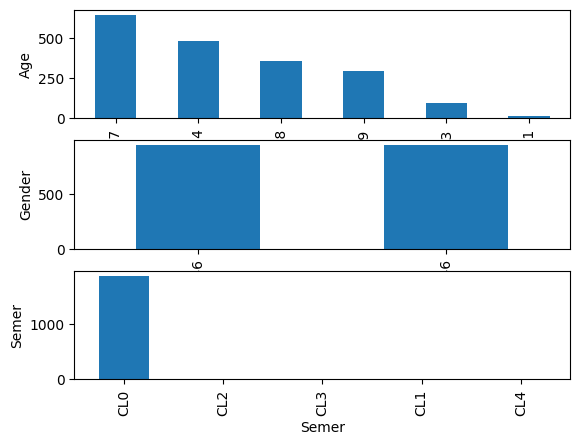

In [121]:
fig,axs = plt.subplots(3,1)
rawData['Age'].value_counts().plot(ax=axs[0],kind='bar')
axs[0].set_ylabel("Age")
rawData['Gender'].value_counts().plot(ax=axs[1],kind='bar')
axs[1].set_ylabel("Gender")
rawData['Semer'].value_counts().plot(ax=axs[2],kind='bar')
axs[2].set_ylabel("Semer")

In [7]:
rawData['Semer'].value_counts()

Semer
CL0    1877
CL2       3
CL3       2
CL1       2
CL4       1
Name: count, dtype: int64

After removing semeron respondants, the data is split between the psychological factors and active drug use factors. From there a few more exploratory plots and tables are generated.

The first cell plots the distribution of psychological factors. It shows what one should expect from a random population sample with normalization of some kind. The means are near, if not at, zero. It appears to have been normalized to be mean zero and standard deviation at a glance and further processing happened after to shift the means from zero. Regardless, with the values already on the same order of magnitude, further normalization will not be necessary.

The second cell shows the correlations of all the psychological factors. The largest correlation is between sensation seeking and impulsiveness, which makes intuitive sense, at 0.62. While significant, this analysis will not attempt to reduce the two on the assumption that the loss of varinace from such a reduction would ultimately negatively impact the analysis. Should the analysis, after review, be worth further investigation, it may be useful to look into reduction. Other than that, very few have notable correlation.

Finally, the third cell shows the counts of active users of various substances, as defined as having used a substance within the past month. As should be expected, the widely legal items of alcohol, caffine, chocolate and nicotine have high active user counts. Cannibis comes in 5th and has much more variable geographic legality so this also makes sense. As for the remainder, further research would be necessary to confirm anything unusual, but these results seem reasonable. 

[Text(1, 0, 'Age'),
 Text(2, 0, 'Gender'),
 Text(3, 0, 'Nscore'),
 Text(4, 0, 'Escore'),
 Text(5, 0, 'Oscore'),
 Text(6, 0, 'Ascore'),
 Text(7, 0, 'Cscore'),
 Text(8, 0, 'Impulsive'),
 Text(9, 0, 'SS')]

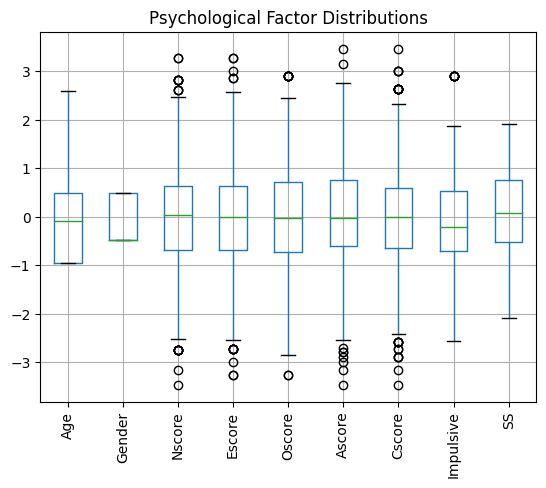

In [11]:
rawData = rawData.loc[rawData.Semer=="CL0",:]
psychColumns = ["Age","Gender","Nscore","Escore","Oscore","Ascore","Cscore","Impulsive","SS"]
substanceColumns = ["Alcohol","Amphet","Amyl","Benzos","Caff","Cannabis","Choc","Coke","Crack","Ecstasy","Heroin","Ketamine","Legalh","LSD","Meth","Mushrooms","Nicotine","VSA"]

psychData = rawData.loc[:,psychColumns]
ax = psychData.boxplot()
ax.set_title("Psychological Factor Distributions")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [12]:
psychData.corr()

,Age,Gender,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
Age,1.000000,0.110546,-0.137952,-0.031433,-0.226795,0.063937,0.184265,-0.191432,-0.331521
Gender,0.110546,1.000000,0.072980,0.058690,-0.133809,0.219119,0.182411,-0.169518,-0.246434
Nscore,-0.137952,0.072980,1.000000,-0.431535,0.007530,-0.217776,-0.392354,0.173384,0.078152
Escore,-0.031433,0.058690,-0.431535,1.000000,0.244784,0.158082,0.307570,0.113695,0.208322
Oscore,-0.226795,-0.133809,0.007530,0.244784,1.000000,0.036846,-0.058607,0.275363,0.419486
Ascore,0.063937,0.219119,-0.217776,0.158082,0.036846,1.000000,0.245438,-0.229945,-0.208319
Cscore,0.184265,0.182411,-0.392354,0.307570,-0.058607,0.245438,1.000000,-0.336175,-0.230334
Impulsive,-0.191432,-0.169518,0.173384,0.113695,0.275363,-0.229945,-0.336175,1.000000,0.622500
SS,-0.331521,-0.246434,0.078152,0.208322,0.419486,-0.208319,-0.230334,0.622500,1.000000


<Axes: >

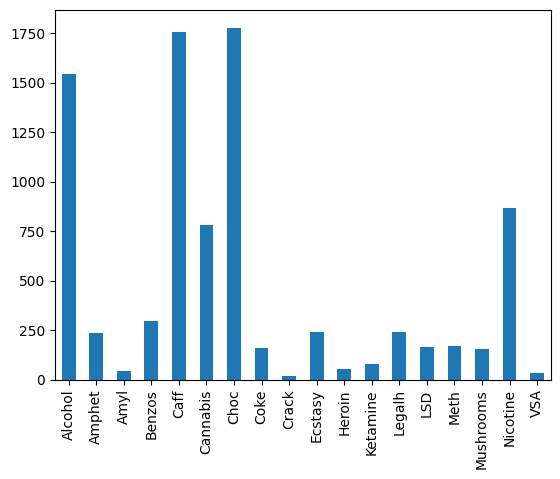

In [13]:
#Split off raw substance based data, sans fake drug and retain it
substanceData = rawData.loc[:,substanceColumns]
#Create boolean array for if a user is active* for a given substance
activeData = np.zeros_like(substanceData)
activeCodes = ["CL4","CL5","CL6"]
for code in activeCodes:
    activeData[substanceData==code]=1
activeData = pd.DataFrame(activeData,columns=substanceColumns)
activeData.sum(axis=0).plot(kind='bar')

# Modeling

As mentioned above, this analysis will be using K-means clustering to attempt to group personality traits.

To begin, the number of clusters to use in the analsis must be chosen. To do this, the clustering algorithm will be run several times using a variable number of kernels and assesed to determine which have possibly useful results. For this, [three clustering metrics are used](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation): the silhouette score, the Calinski-Harabasz index, and the Davies-Bouldin index. Each of these indices scores the resulting clusters on different criteria and were so chosen as they do not need ground truth for evaluation.

The silhouette score measures the clusters in how much they overlap each other. The resulting values range from -1 to 1, with -1 indicating that they completely overlap and 1 indicating that no overlap exists. Of the three metrics, this is the only one who's value has useful meaning by itself, more or less. The two indices, on the other hand, do not have any meaning beyond the relative values in this specific clustering model. The Calinski-Harabasz index measures within-cluster dispersion vs between-cluster dispersion. The larger the value, the better defined the clusters are. Alternatively, the Davies-Bouldin index measures how well separated the clusters are, similar to the silhouette score.

Of the three, the silhouette score and the Calinski-Harabasz index optimizes on maximum values, while the Davies-Bouldin index optimizes on the minimum. For this analysis, the raw table of values is shown to review the silhouette score, and then the results are range normalized to range from zero to one and the resulting Davies-Bouldin indices are inverted so that direct comparison on a single plot is possible, with maxima indicating possibly useful clusters.

Finally, the model itself has very few hyperparameters, traditionally just the number of clusters. In addition to this, the initial kernal location choice is designated to be a random subset of points in the dataset, versus random noise values or other means of choosing. Also, the clustering algorithm is run 20 times and the model with the best inertia value is taken. In a larger dataset, it may be worthwhile to cluster a subset of the data for this step, but the low data density means the whole thing can be done at once.

    Silhouette  CalinskiHarabasz  DaviesBouldin
0     0.174977        452.480953       1.953634
1     0.156791        389.502472       1.821362
2     0.120283        323.841255       2.034115
3     0.115962        282.317180       1.995023
4     0.114082        257.020128       1.936322
5     0.111692        235.124868       1.882226
6     0.107880        216.438528       1.889117
7     0.106234        201.931276       1.909315
8     0.104355        189.471247       1.907226
9     0.103136        179.351524       1.917624
10    0.098914        168.528498       1.910305
11    0.096341        160.574722       1.875113
12    0.097928        154.112574       1.925678
13    0.099708        148.252885       1.827743
14    0.094554        141.620614       1.903988
15    0.094077        136.257058       1.892669
16    0.093932        132.658283       1.904525
17    0.094551        128.786505       1.864521


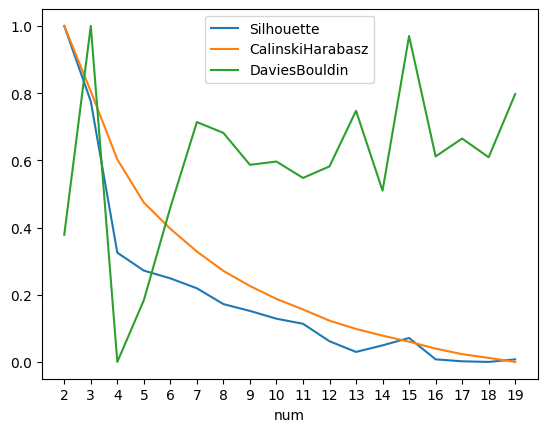

In [16]:
numKernels = range(2,20)
silScore = []
chScore = []
dbScore = []
for x in numKernels:
    m = KMeans(n_clusters=x,init='random',n_init=20)
    m.fit(psychData)
    silScore.append(silhouette_score(psychData,m.labels_))
    chScore.append(calinski_harabasz_score(psychData,m.labels_))
    dbScore.append(davies_bouldin_score(psychData,m.labels_))
clusterScores = pd.DataFrame({"Silhouette":silScore,"CalinskiHarabasz":chScore,"DaviesBouldin":dbScore})
print(clusterScores)
#Normalize for ease of review
clusterScores = (clusterScores - clusterScores.min(axis=0))/(clusterScores.max(axis=0)-clusterScores.min(axis=0))
#Invert Davies-Bouldin indices so that all metrics optimize on maxima
clusterScores.DaviesBouldin = 1-clusterScores.DaviesBouldin
clusterScores["num"] = numKernels

ax = clusterScores.plot(kind='line',x='num',y='Silhouette')
clusterScores.plot(ax=ax,kind='line',x='num',y='CalinskiHarabasz')
clusterScores.plot(ax=ax,kind='line',x='num',y='DaviesBouldin')
ax.set_xticks(clusterScores.num)

The plot above shows constantly decreasing silhouette and Calinski-Harabasz values, generally indicating inconclusive clustering usefulness. Conversely, the Davies-Bouldin indices show several local maxima (minima for the raw value). It has been my personal experience that 2 or 3 clusters are less likely to actaully be useful, despite being a maxima. For this analysis, a closer look at 7 clusters is the direction taken.

Below, a model is fit to 7 clusters using the same kernel initialization strategy and repetitions as used above. The means and standard deviations of the resulting clusters are ploted for review. Of note is the gender standard deviation. It is expected to be lower due to having bounded values. Given the speed of clustering, it's may be worth looking into removing gender from the parameters, which is done below. Beyond that the plots show what you would expect, each cluster has more and less of any given factor with clusters 3 and 6 showing tighter grouping of different factors.

<Axes: xlabel='cluster'>

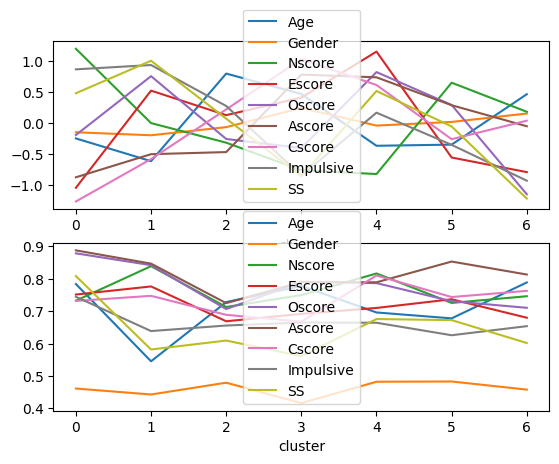

In [18]:
selectedCluster = 7
kmeansModel = KMeans(n_clusters=selectedCluster,init='random',n_init=20)
kmeansModel.fit(psychData)
psychData.loc[:,"cluster"] = kmeansModel.labels_

pMean = psychData.groupby(["cluster"]).mean()
pStd = psychData.groupby(["cluster"]).std()

fig,axs = plt.subplots(2,1)
pMean.plot(ax=axs[0],kind='line',y=["Age","Gender","Nscore","Escore","Oscore","Ascore","Cscore","Impulsive","SS"],stacked=False)
pStd.plot(ax=axs[1],kind='line',y=["Age","Gender","Nscore","Escore","Oscore","Ascore","Cscore","Impulsive","SS"],stacked=False)
# ax.set_xticks(range(selectedCluster))

The below two cells and plots are the same analysis as above, but with gender removed. The Davies-Bouldin indices appear to be much more stable and decreasing, with a bump at 7 clusters again. Also worth noting that the silhouette score also has a local maxima there. It is also worth noting that the two index value sets *cannot* be compaired from the previous run to this one. The removal of gender from the dataset changes the results of the distance formula both are predicated on. Thus, even if 7 clusters was lower on the Davies-Bouldin index on this analysis versus the previous, it cannot be stated that this one is better.

The second cell replicates the mean and standard deviation plots as above. The cluster numeric assignments are randomized each time so directly comparing cluster 6 for both is not comparing the same clusters necessarily. That said, there do appear to be two clusters with similar groupings to clusters 3 and 6 above, though apparently less distinct. For this reason, gender will remain in the dataset for the final model.

    Silhouette  CalinskiHarabasz  DaviesBouldin
0     0.292022        933.788263       1.351023
1     0.253403        800.962909       1.446474
2     0.238419        658.498810       1.482321
3     0.215235        582.821234       1.569766
4     0.203018        539.216733       1.617044
5     0.207673        519.694532       1.592924
6     0.188425        462.490409       1.754900
7     0.181444        416.494100       1.876680
8     0.154899        383.599698       2.043180
9     0.140289        355.561106       2.161327
10    0.134275        333.650517       2.236219
11    0.133481        310.816127       2.148199
12    0.128390        292.044628       2.123892
13    0.116611        275.792120       2.306185
14    0.111841        264.827963       2.321170
15    0.107789        253.953717       2.277502
16    0.108087        245.002054       2.280159
17    0.105817        235.216974       2.222633


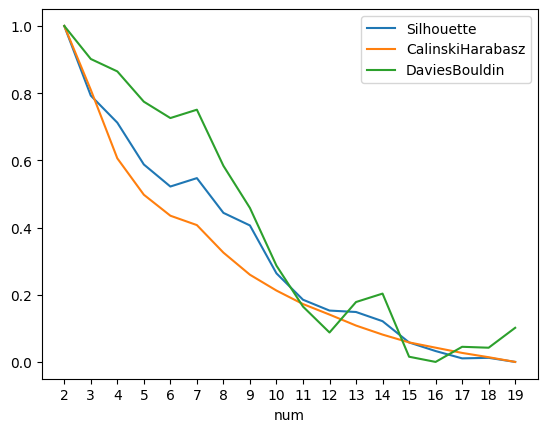

In [20]:
psychData_sansGender = psychData.drop(columns=["Gender"])
numKernels = range(2,20)
silScore = []
chScore = []
dbScore = []
for x in numKernels:
    m = KMeans(n_clusters=x,init='random',n_init=10)
    m.fit(psychData_sansGender)
    silScore.append(silhouette_score(psychData_sansGender,m.labels_))
    chScore.append(calinski_harabasz_score(psychData_sansGender,m.labels_))
    dbScore.append(davies_bouldin_score(psychData_sansGender,m.labels_))
clusterScores = pd.DataFrame({"Silhouette":silScore,"CalinskiHarabasz":chScore,"DaviesBouldin":dbScore})
print(clusterScores)
#Normalize for ease of review
clusterScores = (clusterScores - clusterScores.min(axis=0))/(clusterScores.max(axis=0)-clusterScores.min(axis=0))
#Invert Davies-Bouldin indices so that all metrics optimize on maxima
clusterScores.DaviesBouldin = 1-clusterScores.DaviesBouldin
clusterScores["num"] = numKernels

ax = clusterScores.plot(kind='line',x='num',y='Silhouette')
clusterScores.plot(ax=ax,kind='line',x='num',y='CalinskiHarabasz')
clusterScores.plot(ax=ax,kind='line',x='num',y='DaviesBouldin')
ax.set_xticks(clusterScores.num)

Text(0, 0.5, 'Cluster Standard Deviation')

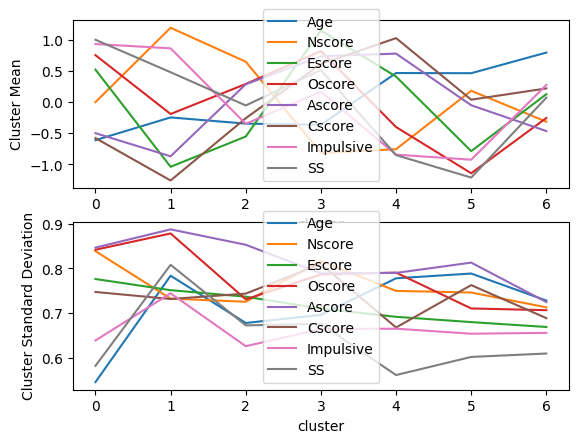

In [22]:
selectedCluster = 7
kmeansModel = KMeans(n_clusters=selectedCluster,init='random',n_init=20)
kmeansModel.fit(psychData)
psychData.loc[:,"cluster"] = kmeansModel.labels_

pMean = psychData.groupby(["cluster"]).mean()
pStd = psychData.groupby(["cluster"]).std()

fig,axs = plt.subplots(2,1)
pMean.plot(ax=axs[0],kind='line',y=["Age","Nscore","Escore","Oscore","Ascore","Cscore","Impulsive","SS"],stacked=False)
axs[0].set_xticks(range(selectedCluster))
axs[0].set_ylabel("Cluster Mean")
pStd.plot(ax=axs[1],kind='line',y=["Age","Nscore","Escore","Oscore","Ascore","Cscore","Impulsive","SS"],stacked=False)
axs[1].set_xticks(range(selectedCluster))
axs[1].set_ylabel("Cluster Standard Deviation")

# Mapping and Observations

Using cluster labels generated by the model below, we are able to map the psychological clusters onto the drug usage information. The first cell below runs the final model and then uses the resulting labels to split the active users into the clusters as a proportion of total active users. A high proporiton of users would theoretically indicate that the personality cluster is more prone to the use of a given substance and vice versa.

In [23]:
kmeansModel = KMeans(n_clusters=7,init='random',n_init=20)
kmeansModel.fit(psychData)
psychData.loc[:,"cluster"] = kmeansModel.labels_

activeData_assigned = activeData
activeData_assigned.loc[:,"cluster"] = kmeansModel.labels_
activeProportion = activeData_assigned.groupby("cluster").sum()/activeData.sum(axis=0) * 100
activeProportion = activeProportion.drop(columns="cluster")

The next two cells plot each user proportion per substance as well as the tabular values for reference. Worth noting are a few things. 

First, the widely legal substances are relatively stable across the clusters generally running 12-17% of the active user population. Nicotine deviates slightly from the pattern, but not hugely so, running from 9-22%.

Second, cluster 1 shows the lowest general proportions of illegal substance use for most substances. This theoretically indicates that this personality cluster is less prone to substance use.

Conversly and third, cluster 5 shows high proportions of usage for most substances, with the highest proportion going to mushrooms at 39.7%. This would indicate that this personality cluster is more prone to substance use.

Text(0, 0.5, 'Proportion of Active User Population (%)')

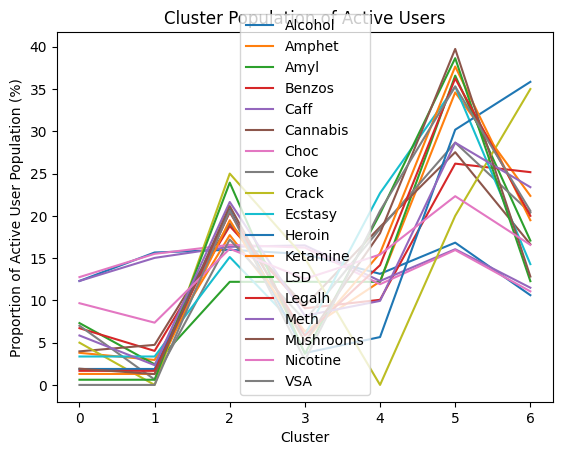

In [28]:
ax = activeProportion.plot(kind='line')
ax.set_xticks(range(selectedCluster))
ax.set_title("Cluster Population of Active Users")
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion of Active User Population (%)")

In [25]:
activeProportion

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,LSD,Legalh,Meth,Mushrooms,Nicotine,VSA
cluster,,,,,,,,,,,,,,,,,,
0,12.297735,3.797468,7.317073,6.711409,12.293682,3.96927,12.752809,7.006369,5.0,3.361345,1.886792,1.298701,0.613497,1.666667,5.847953,1.923077,9.666283,0.0
1,15.66343,2.953586,2.439024,4.026846,15.025612,4.737516,15.505618,0.636943,0.0,3.361345,1.886792,1.298701,0.613497,1.666667,2.339181,1.282051,7.364787,0.0
2,15.987055,17.721519,12.195122,18.791946,16.334661,19.078105,16.573034,17.197452,25.0,15.12605,20.754717,19.480519,23.92638,20.416667,21.637427,21.153846,16.110472,20.588235
3,15.469256,6.329114,12.195122,9.060403,16.505407,9.346991,16.235955,7.643312,15.0,5.882353,3.773585,5.194805,3.680982,5.833333,8.187135,5.128205,12.543153,2.941176
4,13.139159,12.236287,12.195122,10.067114,12.293682,18.693982,11.910112,18.471338,0.0,22.689076,5.660377,15.584416,20.245399,14.166667,9.94152,17.948718,15.420023,20.588235
5,16.828479,34.599156,36.585366,26.174497,16.050085,27.528809,15.955056,28.66242,20.0,35.294118,30.188679,37.662338,38.650307,36.25,28.654971,39.74359,22.324511,35.294118
6,10.614887,22.362869,17.073171,25.167785,11.49687,16.645327,11.067416,20.382166,35.0,14.285714,35.849057,19.480519,12.269939,20.0,23.391813,12.820513,16.570771,20.588235


Finally, these last two plots show the personality factor distributions of the low and high proportion of user cluster (2 and 5 respectively).

In the low user cluster, the stand out values belong to higher neuroticism and lower extraversion. Intuitively individuals prone to anxiety and having smaller friend circles would have more reason to avoid illegal substance use and less ability to obtain them, though that statement alone merits it's own analysis.

In the high user cluster (pun unintended), the notable features are higher extraversion, openness, sensation seeking, and impulsiveness as well as lower agreeableness and contientiousness. Interestingly, neuroticism averaged out to zero. As first pass characterization, the dominant factors are sensation-seeking and impulsivity and otherwise more extreme personality types. As before, further analysis would be warrented

Text(0, 0.5, 'Normalized Cluster Mean')

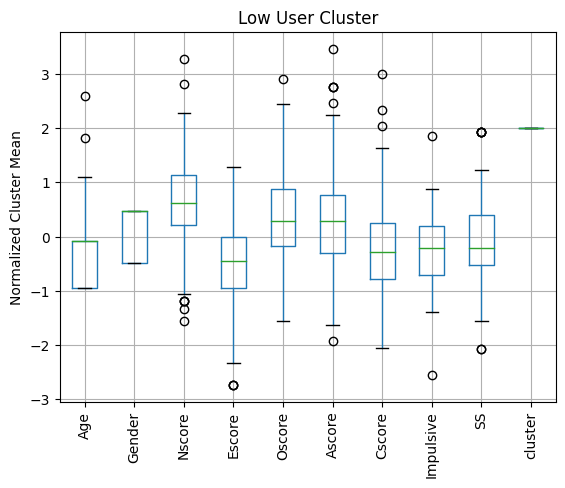

In [33]:
axs = psychData.loc[psychData.cluster==2,:].boxplot()
axs.set_xticklabels(psychData.columns,rotation=90)
axs.set_title("Low User Cluster")
axs.set_ylabel("Normalized Cluster Mean")

Text(0, 0.5, 'Normalized Cluster Mean')

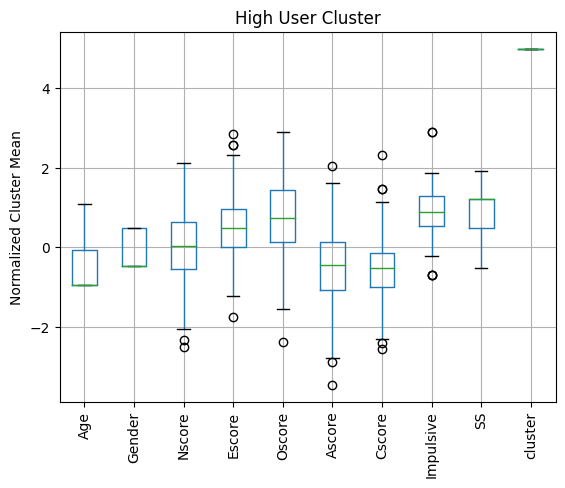

In [34]:
axs = psychData.loc[psychData.cluster==5,:].boxplot()
axs.set_xticklabels(psychData.columns,rotation=90)
axs.set_title("High User Cluster")
axs.set_ylabel("Normalized Cluster Mean")

# Conclusion

There does appeaer to be some personality clusters that are more and less prone to substance use, which makes intuitive sense. Substance abuse is not random and one's personality plays a significant role in one's ability to obtain such substances and willingness to use them. It would also appear that the specific substance used is somewhat random given how they trended together across the clusters with the exception of crack, which had a very low active user population. If personality determined which substance an individual preferred, one would expect them to not trend together as they did. This would indicate that personality biases a person toward using substances in general but not necessarily which substances they use.

For further analysis, several options are available to enhance the results. Factoring in an the ethnicity, country, and education values I suspect would make the clusters more distinct, though possibly prone to splitting and yielding more of them. Designating if a substance is legal or illegal in the respondant's country would likely be useful. Reducing active users to being those within a week, instead of a month, could be worthwhile. Developing a category for individuals in recovery for addiction vs those who have tried it and did not develop an addiction would be very interesting.

In terms of biases in the data, I've already mentioned the binary gender issue. It may not have a large effect, but would likely be worth looking at. Additinally, the question itself may make LGBT respondants more comfortable and more willing to be honest with their responses. Also in the data is the big 5 personality traits themselves and the measurement thereof. Psychological questionnaires and self-reported data is highly prone to subjectivity on the part of the respondant and can change even with one's mood. I do not have a solution to this chronic issue in the field of psychology, I am simply noting it for robustness.

Given that this analysis was conducted for the sake of an exam vs personal interest, there are no significant biases to be reported on from the analysit. My personal background does have above average and unique exposure to the criminal justice system through my teenage years and no notable illegal substance use. This would bias me toward picking the topic itself from the datasets but not toward or away from any conclusion. I am, in fact, a little surprised it worked in any fashion. Professionally, I have found k-means to be suspect and less useful as a model compared to other unsupervised techniques and so any somewhat meaningful results were a pleasant surprise.

# Informational Links
* [Drug Consumption Classification Dataset](https://www.kaggle.com/datasets/mexwell/drug-consumption-classification)
* [Big 5 Personality Traits Wikipedia Article](https://en.wikipedia.org/wiki/Big_Five_personality_traits)
* [Clustering Performance Metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)